In [ ]:
#from transformers import Wav2Vec2Processor,AutoFeatureExtractor,Wav2Vec2Model,AutoFeatureExtractor
import torch
import PreProc
import librosa
import numpy as np
import scipy
from fast_transformers.builders import TransformerEncoderBuilder
from positional_encodings.torch_encodings import PositionalEncoding1D,Summer
import pytorch_lightning as pl
from pytorch_metric_learning import losses
from torch.utils.data import DataLoader,TensorDataset
torch.set_float32_matmul_precision('medium')
import torchaudio
from torchmetrics.wrappers import Running
from torchmetrics.aggregation import MeanMetric
from sklearn.preprocessing import robust_scale
from torch import nn

: 

In [ ]:
X,attended,masker,_ = PreProc.load_data(14)

: 

In [ ]:
class Pearsonr(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self,P,O):

        (n, t) = O.shape      # n traces of t samples
        (n_bis, m) = P.shape  # n predictions for each of m candidates

        DO = O - (torch.einsum("nt->t", O) / n) # compute O - mean(O)
        DP = P - (torch.einsum("nm->m", P) / n) # compute P - mean(P)

        cov = torch.einsum("nm,nt->mt", DP, DO)

        varP = torch.einsum("nm,nm->m", DP, DP)
        varO = torch.einsum("nt,nt->t", DO, DO)
        tmp = torch.einsum("m,t->mt", varP, varO)

        return cov / torch.sqrt(tmp)

: 

In [ ]:
class CLoss(torch.nn.Module):
    def __init__(self,mean,lin,scale):
        super().__init__()
        self.mean = mean
        self.lin = lin
        self.scale = scale
        self.pear = Pearsonr()
        self.temp = 0.7
    
    def forward(self,eemb,aamb):
        if self.mean:
            aamb = torch.mean(aamb,dim=1,keepdim=True)
            eemb = torch.mean(eemb,dim=1,keepdim=True)


        if self.scale:
            eemb =(eemb - eemb.mean(dim=1,keepdim=True))
            aamb =(aamb - aamb.mean(dim=1,keepdim=True))

        
        


        

        logits = (self.pear(eemb,aamb))*np.exp(self.temp)


        t= torch.arange(len(eemb[0]),device=eemb.device)


        l1 = torch.nn.functional.cross_entropy(logits,t)
        #l2 = torch.nn.functional.cross_entropy(logits.T,t.T)



        #labels = torch.arange(len(eemb[0]),device=eemb.device)

    
        return l1

: 

In [ ]:
def prep_EEG(eeg):
    #[b,a] = scipy.signal.butter(3,[10*2,32*2],btype = "bandpass",fs=256)
    #eg = scipy.signal.lfilter(b,a,X,axis=-1)
    eeg = scipy.signal.resample(eeg,4224,axis=-1)
    EEG = []
    for ee in eeg:
        #ee = ee/np.linalg.norm(ee,2)
        #ee = scipy.signal.resample(ee,2112)
        ee = robust_scale(ee,axis=1)
        e = np.split(ee,11,axis=-1)
        EEG.append(e)
    EEG = np.array(EEG)
    EEG = EEG.reshape((EEG.shape[0]*EEG.shape[1], 1, EEG.shape[2],EEG.shape[3]))
    return EEG

: 

In [ ]:
def load_and_prep(filenames,n_splits=11):
    out = []
    for fname in filenames:
        y,_ = librosa.load(fname,sr=16000)
        y = np.abs(scipy.signal.hilbert(y))
        y = scipy.signal.resample(y,4224)
        y_split = np.array(np.split(y,n_splits))
        for i in range(n_splits):
            y_split[i] = (y_split[i]-np.mean(y_split[i]))/np.std(y_split[i])
        out.append(y_split)
    out = np.array(out)
    return out.reshape((out.shape[0]*out.shape[1],out.shape[2]))


: 

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,8,5,padding="same")
        self.drop = nn.Dropout(0.4)
        self.drop2 = nn.Dropout(0.4)
        self.conv2 = nn.Conv2d(8,16,7,padding="same")
        self.conv3 = nn.Conv2d(16,64,1,padding="same")
        self.act = nn.Sigmoid()

        self.avg = nn.AvgPool2d((64,1))

    def forward(self,x):

        out = self.conv1(x)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.drop2(out)
        out = self.conv3(out)

        out = self.avg(out)

        out = out.squeeze(2)
        out = self.act(out)

        return out



: 

In [ ]:
class EEG_Encoder(torch.nn.Module):
    def __init__(self,dff=512,n_layers=8,n_heads=4,times = 384):
        super().__init__()

        self.cn = CNN()
        self.times = times
        self.posenc = Summer(PositionalEncoding1D(64))
        self.encl = nn.TransformerEncoderLayer(d_model=256,nhead=n_heads,dropout=0.4,activation="gelu",batch_first=True,dim_feedforward=1024)
        self.enc = nn.TransformerEncoder(self.encl,num_layers=n_layers,norm = nn.LayerNorm([self.times,256]))

        self.conv1 = nn.Conv2d(1,16,(1,10),padding="valid")
        self.avg = nn.AvgPool2d(kernel_size = (1,8),stride=(1,4))
        self.conv2 = nn.Conv2d(16,16,(64,1),padding="valid")
        self.flat = nn.Flatten()
        self.linl = nn.LazyLinear(384)
        


        
        
    def forward(self,x):

        out = self.cn(x)
        out = torch.permute(out,(0,2,1))
        x = x.squeeze(1)
        x = torch.permute(x,(0,2,1))
        out = x*out
        out = self.posenc(out)

        out = torch.permute(out,(0,2,1))
        out = out.unsqueeze(1)

        out = self.conv1(out)
        out = self.avg(out)
        out = self.conv2(out)
        out = self.flat(out)
        out = self.linl(out)

       
    
        return out

: 

In [ ]:
enc = EEG_Encoder()
x= torch.rand([1,1,64,768])
out = enc(x)

: 

In [ ]:
EEG = prep_EEG(X)

: 

In [ ]:
EEG.shape

: 

In [9]:
att = load_and_prep(attended)
mas = load_and_prep(masker)

In [42]:
att.shape

(2640, 384)

In [10]:
class LitAutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = EEG_Encoder()
        #self.linl = torch.nn.Linear(768,256).to('cuda')
        self.loss_fn = CLoss(mean=False,lin=False,scale=True)
        self.running_loss = Running(MeanMetric(), window=10)
        #self.audmod = Wav2Vec2Model.from_pretrained("Clementapa/wav2vec2-base-960h-phoneme-reco-dutch"
        #self.los = criterion()

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        return embedding

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        eeg,att = batch

        
        
        eeg_emb = self.encoder(eeg)

        #temb = torch.cat([att,mas])


        



        loss = self.loss_fn(eeg_emb.T,att.T)

        self.running_loss(loss)
        tqdm_dict = {'train_loss': loss}
        self.log('train_loss', self.running_loss.compute(), on_step=True, prog_bar=True)
        outputs = {
            'loss': loss,
            'progress_bar': tqdm_dict,
            'log': tqdm_dict
        }
        return outputs
    
    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        eeg,att = batch
        


        
        
        eeg_emb = self.encoder(eeg)

        #temb = torch.cat([att])
        


        loss = self.loss_fn(eeg_emb.T,att.T)
        tqdm_dict = {'val_loss': loss}
        self.running_loss(loss)
        self.log('val_loss', self.running_loss.compute(), on_step=True, prog_bar=True)

        outputs = {
            'loss': loss,
            'progress_bar': tqdm_dict,
            'log': tqdm_dict
        }
        return outputs

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
        return optimizer

In [11]:
from sklearn.model_selection import train_test_split

X_tr,x_val,att_tr,att_val,mas_tr,mas_val = train_test_split(EEG,att,mas,test_size=0.1)


NameError: name 'EEG' is not defined

In [ ]:
EEG_tr = torch.Tensor(X_tr)
att_tr = torch.Tensor(att_tr)
mas_tr = torch.Tensor(mas_tr)

trdata = TensorDataset(EEG_tr,att_tr)

train_loader = DataLoader(trdata, batch_size=32, num_workers=4, shuffle=True,persistent_workers=True)


EEG_val = torch.Tensor(x_val)
att_val = torch.Tensor(att_val)
mas_val = torch.Tensor(mas_val)

valdata = TensorDataset(EEG_val,att_val)

val_loader = DataLoader(valdata, batch_size=32, num_workers=4,persistent_workers=True)

In [ ]:
enc = LitAutoEncoder()

trainer = pl.Trainer(max_epochs=100,accelerator='gpu')
trainer.fit(enc, train_loader,val_dataloaders=val_loader)

c:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:454: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.

  | Name         | Type        | Params
---------------------------------------------
0 | encoder      | EEG_Encoder | 7.3 M 
1 | loss_fn      | CLoss       | 0     
2 | running_loss | Running     | 0     
---------------------------------------------
7.3 M     Trainable para

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [48]:
i=5
enc.cpu()
out = enc(EEG_tr[i].unsqueeze(0))

In [49]:
out.shape

torch.Size([1, 384])

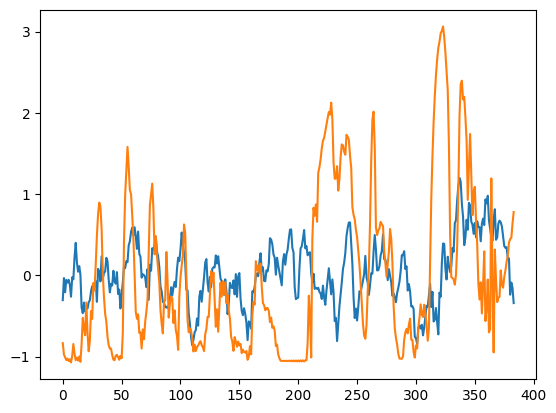

In [50]:
import matplotlib.pyplot as plt
plt.plot(out[0].cpu().detach().numpy())
plt.plot(att_tr[i].cpu().detach().numpy())